In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

C:\Users\Sim Jia Yao\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sim Jia Yao\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sim Jia Yao\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sim Jia Yao\AppData\Roami

In [2]:
# nltk.download('wordnet')

In [3]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [4]:
data = load_doc('C:/Users/Sim Jia Yao/Desktop/Natural Language Processing/NLP-Tennis-Bot-master/intents1.json')

In [5]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [6]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

,questions,labels
0,Hi there,start_conversation
1,Is anyone there?,start_conversation
2,Hey,start_conversation
3,Hola,start_conversation
4,Hello,start_conversation
...,...,...
107,Lookup for hospital,hospital_search
108,Searching for hospital to transfer patient,hospital_search
109,I want to search hospital data,hospital_search
110,Hospital lookup for patient,hospital_search


In [7]:
df1.labels.value_counts(sort=False)
print(len(df1.labels.value_counts(sort=False)))

21


In [8]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

,response,labels
0,"Hello, I'm sure you love tennis",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm BoTennis",what_are_you


In [9]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [10]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

In [11]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [12]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [13]:
print(vocab.most_common(20))

[('tennis', 36), ('the', 24), ('what', 23), ('you', 22), ('are', 19), ('do', 16), ('for', 11), ('how', 11), ('in', 11), ('rule', 11), ('blood', 10), ('pressure', 10), ('to', 9), ('list', 9), ('me', 7), ('can', 7), ('know', 7), ('about', 7), ('is', 6), ('player', 6)]


In [14]:
vocab_size = len(vocab)
vocab_size

160

In [15]:
df1

,questions,labels
0,hi there,start_conversation
1,is anyone there,start_conversation
2,hey,start_conversation
3,hola,start_conversation
4,hello,start_conversation
...,...,...
107,lookup for hospital,hospital_search
108,searching for hospital to transfer patient,hospital_search
109,want to search hospital data,hospital_search
110,hospital lookup for patient,hospital_search


In [16]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['how to check adverse drug reaction',
 'open blood pressure module',
 'want to search for blood pressure result history',
 'what do you know about tennis',
 'each line on the tennis court mean whats',
 'bye',
 'who serf first',
 'what are the general rule of tennis',
 'lookup for hospital',
 'what are the tennis kit need to get started',
 'what are the match format in tennis',
 'how can you help me',
 'find me pharmacy',
 'how is score counted',
 'what are the service rule',
 'hi there',
 'do you know tennis game type',
 'thanks',
 'what will happen if game end in same score',
 'who are the top player in tennis',
 'what is your name']

In [17]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index
print(len(test_index))

21


In [18]:
train_index = [i for i in df1.index if i not in test_index]

In [19]:
' '.join(list(vocab.keys()))

'hi there is anyone hey hola hello good day what your name are you who pls bye see later goodbye nice chatting to till next time thanks thank thats helpful awesome for helping me how can help do provide be support offered know about tennis tell really lot exactly mean by guide through the top player in list best general rule of playing kit need get started wear beginner full will each line on court whats why so many where base serf first decide serve anybody service stand anywhere game type different explain happen if end same score tiebreak doe work winner when tie break counted scoring board count match format we just keep tired set stop played check adverse drug reaction open module give causing behavior all suitable patient with which dont have blood pressure task related data entry want log result management search history load show find id pharmacy nearby locate lookup hospital searching transfer looking up detail'

In [20]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [21]:
X,vocab_size = encoder(df1,'questions')

In [22]:
df_encoded = pd.DataFrame(X)

In [23]:
df_encoded['labels'] = df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,58,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
1,19,82,33,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
2,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
3,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
4,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation


In [24]:
for i in range(0,2):
    dt = [0]*16
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {16:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [25]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
109,55,13,56,32,54,0,0,0,0,0,0,0,0,0,0,0,hospital_search
110,32,81,7,23,0,0,0,0,0,0,0,0,0,0,0,0,hospital_search
111,158,159,32,160,0,0,0,0,0,0,0,0,0,0,0,0,hospital_search
112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused
113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused


In [26]:
train_index.append(112)

In [27]:
test_index.append(113)

In [28]:
# df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [29]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [30]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21,  6,  6,  6,  6,  6, 18,
       18, 18, 18, 18, 12, 12, 12, 12, 12, 12, 12, 12,  3,  3,  3,  3,  3,
       20, 20, 20, 20, 20, 20,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10,  5,  5,  5,  7,  7,  7,  7, 15, 15, 15, 15, 15, 15,
       17, 17, 17, 17, 19, 19, 19, 19, 19, 14, 14, 14, 14, 14, 11, 11, 11,
       11, 11,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
       13, 13, 13, 13, 13,  9,  9,  9,  9,  9,  4,  4])

In [31]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'start_conversation': 16,
 'what_are_you': 21,
 'end_conversation': 6,
 'thanks': 18,
 'options': 12,
 'bot_scope': 3,
 'top_players': 20,
 'general_rules': 8,
 'kits': 10,
 'court_lines': 5,
 'first_server': 7,
 'serving_rules': 15,
 'tennis_games': 17,
 'tie_break': 19,
 'scoring': 14,
 'match_format': 11,
 'adverse_drug': 0,
 'blood_pressure': 1,
 'blood_pressure_search': 2,
 'pharmacy_search': 13,
 'hospital_search': 9,
 'confused': 4}

In [32]:
df2.head()

,response,labels
0,"Hello, I'm sure you love tennis",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm BoTennis",what_are_you


In [33]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,"Hello, I'm sure you love tennis",16
1,Happy to have you here,16
2,Good to see you again,16
3,"Hi there, how can I help?",16
4,"Hi, I'm BoTennis",21


In [34]:
df2.to_csv('response.csv',index=False)

In [35]:
# df2.groupby('labels').get_group(11)

In [36]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]
print(len(train))
print(len(test))

92
22


In [37]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels
y_train.shape,y_test.shape

((92,), (22,))

In [38]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values
y_train.shape,y_test.shape

((92, 22), (22, 22))

In [39]:
y_train[0].shape,y_test[0].shape

((22,), (22,))

In [40]:
X_train.shape

(92, 16)

In [41]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 23

In [42]:
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='softmax'))
    
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
# #     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [43]:
max_length

16

In [44]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [51]:

def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4,activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(22,activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [52]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 300)           48300     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 64)            76864     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                1430      
Total params: 126,594
Trainable params: 126,594
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(X_train, y_train, epochs=100, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Train on 92 samples, validate on 22 samples
Epoch 1/100
32/92 [=========>....................] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 00001: val_loss did not improve from 0.64800
92/92 [==============================] - 0s 4ms/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6480 - val_acc: 0.7273
Epoch 2/100
32/92 [=========>....................] - ETA: 0s - loss: 0.0018 - acc: 1.0000
Epoch 00002: val_loss did not improve from 0.64800
92/92 [==============================] - 0s 390us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6480 - val_acc: 0.7273
Epoch 3/100
32/92 [=========>....................] - ETA: 0s - loss: 0.0012 - acc: 1.0000
Epoch 00003: val_loss did not improve from 0.64800
92/92 [==============================] - 0s 336us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6480 - val_acc: 0.7273
Epoch 4/100
32/92 [=========>....................] - ETA: 0s - loss: 0.0018 - acc: 1.0000
Epoch 00004: val_loss did not improve from 0.64800

Epoch 00004: ReduceLROnP

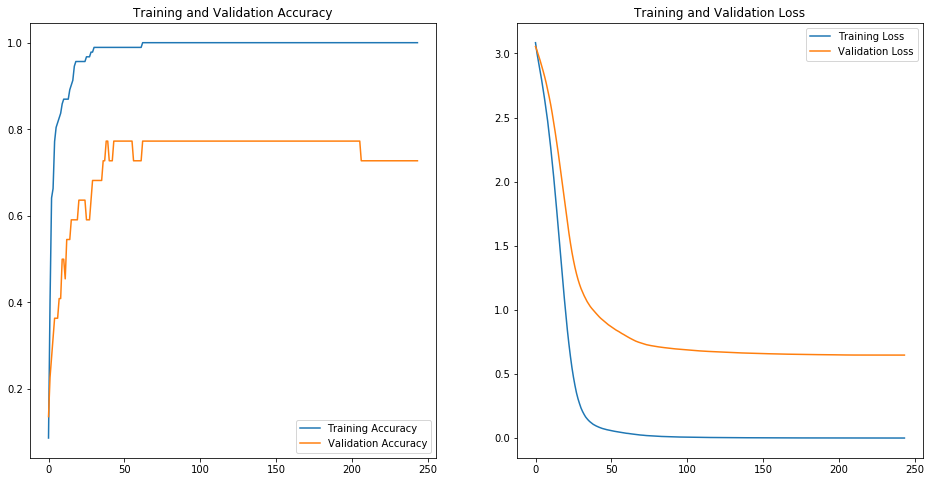

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 2, 1, 3, 5, 4, 4, 8, 9, 10]

In [56]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10]

## New user question encoding

In [57]:
def get_text():
    input_text  = ['what are you']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input 

In [58]:
#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [59]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [60]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [61]:
# df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
# df_input

In [62]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=16, padding='post')
    return padded

In [63]:
# encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
# encoded_input.shape

In [64]:
# encoded_input

In [65]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [66]:
# mapper

In [67]:
# df2.head()

In [68]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [69]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
    

In [70]:
def bot_response(response,):
    print(response)

In [71]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

Call me BoTennis


In [72]:
import streamlit as st

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
st.image()